# Super-Resolution and Image Restoration (img2img task) - Flickr2K dataset

*Ciao*! Welcome to this personal project, which represents an evolution of my initial university work on [image super-resolution](https://github.com/kugogt/University_projects/tree/main/Foundation_of_DeepLearning). From the original project, this "upgrade"has the aim to incorporating more advanced techniques, improving performance and building a more robust and realistic training pipeline.

The core is a new U-Net architecture designed for 2x image super-resolution and image restoration. It is built with several state-of-the-art techniques before the "adoption" of Transformers.

## Upgrades
* **U-Net Architecture**: now it includes:
    1. **Squeeze-and-Excitation (SE) Blocks**: allows to re-weight channel features;
    2. **PixelShuffle**: advanced upsampling method compared to Conv2DTranspose;
    3. **Global Residual Learning**: the model predicts the residual between a simple upsampled image and the ground truth;
    4. **Layer Normalization**: used instead of BatchNormalization;
    5. **Dropout**: improve regularization in the bottleneck and decoder;
* **Mixed Precision**: to speed up computation on compatible GPU;
* **Degradation Pipeline**: it has been added JPEG compression to existing degradation;
* **Data Augmentation**: it has been added hue, saturation and vertical flip
* **Full Image Inference**: unlike the previous version, there is inference on full-sized images.

## Preparing for GAN
The use of a tanh activation function in the final layer and the normalization of all image data to the [-1, 1] range is useful to prepare the next future step: GAN-based loss. This current architecture will be used to do it, so... STAY TUNED

## Image Data Lifecycle
To fully understand the pipeline, which includes different functions and normalizations, it's helpful to trace the "journey" of an image. 
### 1. Training & Validation:
Tranining and validation are handled by the "tf.data" pipeline via the "load_and_preprocess" function.

1. **File Path**: the process starts with a string representing the path to an image file (for ex. "/kaggle/input/flickr2k/Flickr2K/000001.png")
2. **Readn & Decode**:
   *  "tf.io.read_file" reads the raw binary data of the image.
   *  "tf.io.decode_png" decodes this data into a tf.Tensor of shape (H, W, 3) with pixel values in the range [0, 255].
   *  "tf.image.convert_image_dtype(img, tf.float32)" converts the data type to float32 and normalizes the pixel values to the range [0, 1].
3. **Patch Extraction and Augmentation**: a 256*256 High-Resolution (HR) patch is extracted from the full image (in training mode, augmentations are applied).
4. **Degradation**: degradation_pipeline_np function is called with the [0, 1] HR patch. Inside of it:
     * The patch is denormalized back to [0, 255] to be compatible with OpenCV functions.
     * Degradations are applied.
     * Low-Resolution (LR) patch is clipped to ensure its values stay within [0, 255].
     * Re-normalized back to [0, 1].
       
   The output is a 128x128 LR patch as a float32 tensor in the [0, 1] range.
5. **Final Normalization for Model Input**: both the LR and HR patches are scaled to match the model's expected input and output range (tanh acivation function is used)
    * LR Patch (Model Input X): scaled from [0, 1] to [-1, 1].
    * HR Patch (Ground Truth y_true): scaled from [0, 1] to [-1, 1]

### 2. Inference & Visualization:
Generate a SR & Restored image from a new LR input and dosplay results.

1. **Prepare Model Input**: load an HR image ([0, 1]), extract a patch or use the full image, and run it through the degradation pipeline to get an LR image ([0, 1]). This is then normalized to [-1, 1].
2. **Model Prediction**: "model.predict()" is called on LR input. Thanks to the tahn at the end, the model's output (the predicted SR image) is in range [-1, 1].
3. **Denormalization for Visualization**: "Matplotlib" expect values to be in range [0, 255] or [0, 1]... The model's output is, instead, in [-1, 1] range. The "denorm" function is used to convert the image from [-1, 1] to [0, 1].
4. **Display**: done by "plt.imshow()":
    * LR input from [-1, 1] became [0, 1] thanks to the denorm function
    * SR predicted output from [-1, 1] became [0, 1] thanks to the denorm function
    * HR ground truth was kept in [0, 1]

The visualization is done!

In [1]:
# --- Libraries

import os
import glob
import numpy as np
import cv2
import matplotlib.pyplot as plt
import random
import math
from tqdm import tqdm
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.applications.vgg19 import VGG19, preprocess_input
from tensorflow.keras.models import load_model
from tensorflow.keras import metrics
from tensorflow.keras.saving import register_keras_serializable
from sklearn.model_selection import train_test_split

2025-08-16 11:17:34.303191: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1755343054.654028      19 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1755343054.746609      19 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
# --- 1 Configuration

# 1.1 Seeds
np.random.seed(2077)
tf.random.set_seed(2077)
random.seed(2077)

# 1.2 Set the global policy for mixed precision.
policy = tf.keras.mixed_precision.Policy("mixed_float16")
tf.keras.mixed_precision.set_global_policy(policy)

# 1.3 Patch dimensions for High-Resolution (HR) and Low-Resolution (LR) images
PATCH_H = 256                          # Height of the HR image patches
PATCH_W = 256                          # Width of the HR image patches
PATCH_LR_H = PATCH_H // 2              # Height of the LR image patches (128)
PATCH_LR_W = PATCH_W // 2              # Width of the LR image patches (128)
UPSCALE_FACTOR = 2                     # scale factor (2x super-resolution)
CH = 3                                 # RGB

# 1.4 Training
BATCH_SIZE      = 32
EPOCHS          = 100
SAMPLE_SIZE     = None                 # None = full data

# Data Loading and Preprocessing
This section handles the steps of preparing the dataset for the model task. The pipeline is designed by creating paired low-resolution (LR) and high-resolution (HR) image patches for training.

The key stages are:
1.  **Path Collection and Splitting:** Gather the file paths of all images and split them into training, validation, and test sets.
2.  **Dataset Sanity Check:** Verify the minimum dimensions of the images to ensure the patch extraction is valid.
3.  **Degradation Function:** A custom function is defined to simulate real-world image degradation and creating realistic LR images from HR patches. This includes downsampling, blur, noise, and JPEG compression.
4.  **"tf.data" Pipeline:** An input pipeline using "tf.data.Dataset" that handles image loading, augmentation, degradation, batching, and prefetching.

## Image Path Collection and Dataset Splitting
Scan the dataset directory to collect the file paths of all available PNG images. The collected paths are then deterministically split into three distinct sets:
-   **Training Set (72%):** Used to train the model.
-   **Validation Set (18%):** Used to monitor the model's performance during training.
-   **Test Set (10%):** An held-out set used for the final evaluation of the trained models.

In [3]:
# --- 2 Collection of image paths

base_folder = '/kaggle/input/flickr2k/Flickr2K'
all_paths = []

pattern = os.path.join(base_folder, f"*.png")           # All the images are png format
for f in glob.glob(pattern):
        if os.path.getsize(f) > 0:                      # Ensure that each file is not empty (>0)
           all_paths.append(f)

train_paths, test_paths = train_test_split(all_paths, test_size=0.1, random_state=2077)      # 15% of the whole data for test
train_paths, val_paths  = train_test_split(train_paths, test_size=0.2, random_state=2077)    # 20% of the remaning for validation

print(f"In the dataset there are 2650 images, I was able to identify {len(all_paths)} images.")
print(f"Of these {len(all_paths)} image, {len(train_paths)} will be used for training, {len(val_paths)} will used for validation and {len(test_paths)} will be used for test.")

In the dataset there are 2650 images, I was able to identify 2650 images.
Of these 2650 image, 1908 will be used for training, 477 will used for validation and 265 will be used for test.


## Dataset Sanity Check
Perform a sanity check on the image dimensions across the entire dataset. This step iterates through all images to find the minimum height and width. This is done to confirm that my chosen HR patch size ("256x256") can be safely extracted from every image.

In [4]:
# --- 3 Minimum height and witdh between all images.
# This step helps to understand the variability in image sizes and ensure that the chosen patch size (256x256) is feasible
# by checking if all original images are at least as large as the desired patch size.

min_height = np.inf
min_width  = np.inf

for path in all_paths:
    img = cv2.imread(path, cv2.IMREAD_UNCHANGED)      # Read image by keeping its original channel count
    if img is None:
        print(f"Can't read this image: {path}")
        continue

    h, w = img.shape[:2]                              #Get height and width
    if h < min_height:
        min_height = h
    if w < min_width:
        min_width = w

if min_height == np.inf or min_width == np.inf:
    print("No valid image")
else:
    print(f"Minimum hight between all images : {min_height}")
    print(f"Minimum width between all images : {min_width}")

Minimum hight between all images : 816
Minimum width between all images : 1020


## Degradation Function
To train the model, we need pairs of low-resolution (LR) and high-resolution (HR) images. The function takes a high-resolution image as a NumPy array [0, 1] and applies a randomized degradation sequence. It returns a low-resolution image, also as a NumPy array in [0, 1].

The degradation applied are:
1.  **Downsampling:** The image is downscaled by a factor of 2.
2.  **Gaussian Blur:** A Gaussian blur is applied to soften details.
3.  **Gaussian Noise:** Additive Gaussian noise to mimic sensor noise.
4.  **JPEG Compression:** The image is subjected to JPEG compression.

In [5]:
# --- 4 Degradation Function
# This function will be used for creating low-resolution images.
# It takes a high-resolution image [0, 1] and returns a degraded low-resolution version [0, 1].

def degradation_pipeline_np(image_input):

    # 4.1 Handle both Tensor and NumPy array inputs
    if isinstance(image_input, tf.Tensor):
        hr_image_np = image_input.numpy()  # input Tensor -> NumPy
    else:
        hr_image_np = image_input  # NumPy

    # 4.2 Denormalize from [0, 1] to [0, 255] for OpenCV operations
    # Now use the NumPy array for all subsequent operations
    img = (hr_image_np * 255.0).astype(np.float32)
    h, w, _ = img.shape             # Dynamic shape to apply the function to both a patch & a full-image
    lr_h, lr_w = h // UPSCALE_FACTOR, w // UPSCALE_FACTOR     
 
    # 4.3 Downsample
    small = cv2.resize(img, (lr_w, lr_h), interpolation=cv2.INTER_AREA)

    # 4.4 Gaussian Blur
    kernel_size = random.choice([(3, 3), (5, 5), (7, 7)])
    sigma_x = np.random.uniform(0.5, 2.5)
    small = cv2.GaussianBlur(small, kernel_size, sigma_x)

    # 4.5 Gaussian Noise
    noise_std = np.random.uniform(5, 35)
    noise = np.random.normal(0, noise_std, small.shape).astype(np.float32)
    small = small + noise

    # 4.6 JPEG Compression (random)
    if np.random.rand() < 0.5:
        quality = np.random.randint(30, 95)
        _, enc = cv2.imencode(".jpg", small, [int(cv2.IMWRITE_JPEG_QUALITY), quality])
        small = cv2.imdecode(enc, 1).astype(np.float32)

    # 4.7 Clip to [0, 255] and re-normalize to [0, 1]
    small_clipped = np.clip(small, 0.0, 255.0)
    lr_final = small_clipped / 255.0

    return lr_final.astype(np.float32)

I0000 00:00:1755343412.565258      19 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1755343412.565936      19 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5
[ WARN:0@361.968] global loadsave.cpp:1329 imencode Unsupported depth image for selected encoder is fallbacked to CV_8U.


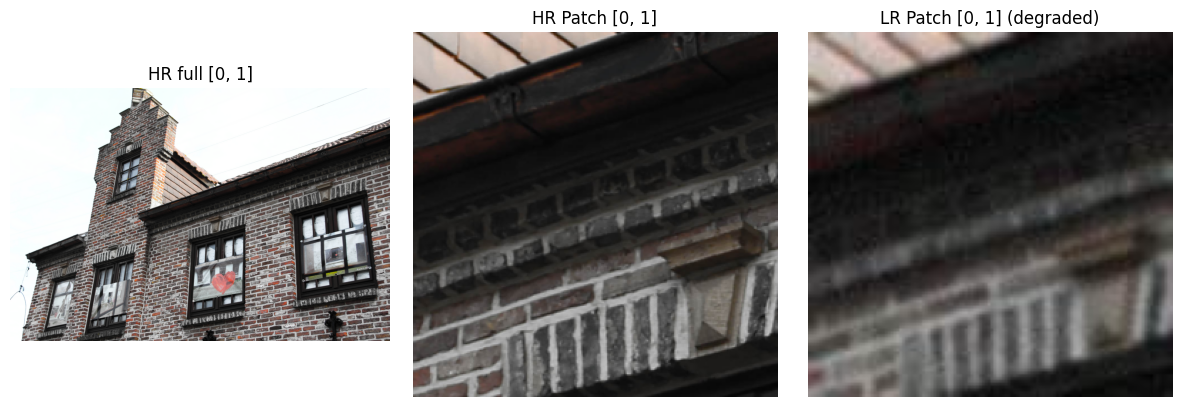

In [6]:
# --- 5 Visualization of the degradation function

# 5.1 Select a random image from train
random_path = random.choice(train_paths)
hr_full = tf.image.convert_image_dtype(tf.io.decode_png(tf.io.read_file(random_path), channels=CH), tf.float32)
hr_patch = tf.image.resize_with_crop_or_pad(hr_full, PATCH_H, PATCH_W)

# 5.2 Apply  degradation
lr_patch_degraded = degradation_pipeline_np(hr_patch.numpy())

plt.figure(figsize=(12, 4))
plt.subplot(1, 3, 1)
plt.title("HR full [0, 1]")
plt.imshow(hr_full)
plt.axis("off")
plt.subplot(1, 3, 2)
plt.title("HR Patch [0, 1]")
plt.imshow(hr_patch)
plt.axis("off")
plt.subplot(1, 3, 3)
plt.title("LR Patch [0, 1] (degraded)")
plt.imshow(lr_patch_degraded)
plt.axis("off")
plt.tight_layout()
plt.show()

## "tf.data" Preprocessing Function

 The function "load_and_preprocess" forms the core of the data pipeline.
 1.  **Load and Normalize to [0, 1]:** Reads an image file and converts it to float32 in the [0, 1] range.
 2.  **Patch Extraction and Augmentation:** Extracts an HR patch ([0, 1]).
 3.  **Degradation:** The HR patch is passed to our degradation_pipeline_np function to generate the corresponding LR patch ([0, 1]).
 4.  **Final Normalization to [-1, 1]:** Both the LR and HR patches are normalized to the [-1, 1] range, which is the format the model expects for training.

In [7]:
# --- 6 Data loading and preprocessing function

def load_and_preprocess(path, training):
    # 6.1 Read and decode HR image to [0, 1]
    img = tf.io.read_file(path)
    img = tf.io.decode_png(img, channels=CH)
    img = tf.image.convert_image_dtype(img, tf.float32)

    # 6.2 Extract HR 256×256 patch and apply augmentations (still [0, 1])
    if training:
        # Crop
        hr_patch = tf.image.random_crop(img, [PATCH_H, PATCH_W, CH])
        # Horizontal Flip         
        hr_patch = tf.image.random_flip_left_right(hr_patch)
        # Vertical Flip
        hr_patch = tf.image.random_flip_up_down(hr_patch)
        # Rotation (0, 90, 180, 270 degrees)
        k = tf.random.uniform([], 0, 4, tf.int32)
        hr_patch = tf.image.rot90(hr_patch, k)
        # --- Colour Augmentations 
        hr_patch = tf.image.random_brightness(hr_patch, max_delta=0.1)                 # Brightness
        hr_patch = tf.image.random_contrast(hr_patch, lower=0.8, upper=1.2)            # Contrast
        hr_patch = tf.image.random_saturation(hr_patch, lower=0.85, upper=1.15)        # Saturation   
        hr_patch = tf.image.random_hue(hr_patch, max_delta=0.08)                       # Hue
        # Ensure all values are valid after color aug
        hr_patch = tf.clip_by_value(hr_patch, 0.0, 1.0)
    else:
         # For validation/testing, just do a center crop
        hr_patch = tf.image.resize_with_crop_or_pad(img, PATCH_H, PATCH_W)

    # 6.3 Generate LR patch [0, 1] using the degradation pipeline
    lr_patch_0_1 = tf.py_function(
        func=degradation_pipeline_np,
        inp=[hr_patch],
        Tout=tf.float32
    )

    # 6.4 Normalize both patches to [-1, 1] for the model
    lr_patch = (lr_patch_0_1 * 2.0) - 1.0
    hr_patch_norm = (hr_patch * 2.0) - 1.0

    # 6.5 Set static shapes
    lr_patch.set_shape([PATCH_LR_H, PATCH_LR_W, CH])
    hr_patch_norm.set_shape([PATCH_H, PATCH_W, CH])

    return lr_patch, hr_patch_norm

## Building the Datasets
Using the preprocessing function defined above, I now construct my final datasets for training, validation, and testing.

In [8]:
# --- 7 Dataset creation

def make_dataset(paths, training):

    ds = tf.data.Dataset.from_tensor_slices(paths)
    if training:
        ds = ds.shuffle(buffer_size = len(paths))               # shuffle training data for randomness
    ds = ds.map(lambda p: load_and_preprocess(p, training),     # Map the "load_and_preprocess" function to each element in the dataset
                num_parallel_calls = tf.data.AUTOTUNE)          # "tf.data.AUTOTUNE" is used for better performance
    ds = ds.batch(BATCH_SIZE)                                   # Create Batch of the preprocessed elements
    ds = ds.prefetch(tf.data.AUTOTUNE)                          # Pre-fetches the next batches of data while the GPU is busy with the current one
    return ds

if SAMPLE_SIZE is not None:                                     # For debug
    train_paths = train_paths[:SAMPLE_SIZE]
    val_paths   = val_paths[:SAMPLE_SIZE//5]
    test_paths  = test_paths[:SAMPLE_SIZE//5]

train_ds = make_dataset(train_paths, training=True)             # Create training
val_ds   = make_dataset(val_paths,   training=False)            # Create validation
test_ds  = make_dataset(test_paths,  training=False)            # Create test

print(f"Train: {len(train_paths)}, Val: {len(val_paths)}, Test: {len(test_paths)}")

print(train_ds)
print(val_ds)
print(test_ds)

Train: 1908, Val: 477, Test: 265
<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 128, 128, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None))>
<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 128, 128, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None))>
<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 128, 128, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None))>


# Model Architectures
The U-Net is a powerful convolutional neural network characterized by its U-shaped encoder-decoder architecture. Its unique feature are the skip connections: they connect encoder layers with corresponding decoder layers, allowing the recovery of spatial information lost during the downsampling phase.

My model utilizes a "hybrid" U-Net architecture. The standard encoder-decoder structure with skip connections is used for its proven effectiveness in image restoration tasks, allowing for the fusion of features from multiple spatial scales. To enhance its super-resolution capabilities, I replaced the traditional simple bottleneck with a deep stack of residual blocks. This design is inspired by state-of-the-art super-resolution networks and acts as a powerful feature extractor, focusing on learning the residual high-frequency information.

I also wanted to add:
* Squeeze-and-Excitation (attention block): this block learns to give more "weight" to the most important channels (features);
* PixelShuffle: "enanched" upsampling method compared to "conv2dtranspose"
* Global residaul: a zoomed-in version of the input with a simple interpolation;
* Layer normalization: normalizes across all feature maps (channels) for each spatial location within each image.

In [9]:
# --- 8 U-Net 
 
NUM_BOTTLENECK_BLOCKS = 6

# Squeeze-and-Excitation. 
# Squeeze-and-Excitation Networks" (SENet) by "Jie Hu et al., 2018 (CVPR)" 
def se_block(input_tensor, ratio=8):
    channels = input_tensor.shape[-1]
    se = layers.GlobalAveragePooling2D()(input_tensor)                                   # Squeeze: Aggregates spatial information into a single value per channel
    se = layers.Reshape((1, 1, channels))(se)                                            # Vector of shape (1,1,C)
    se = layers.Conv2D(channels // ratio, 1, activation = "relu", use_bias=True)(se)     # Excitation: Learn a nonlinear gating function to weight the channels.
    se = layers.Conv2D(channels, 1, activation = "sigmoid", use_bias=True)(se)           # 1x1 convolution that restores the number of channels back to the original C
    return layers.Multiply()([input_tensor, se])                                         # Apply weights to the input tensor

# PixelShuffle
# Real-Time Single Image and Video Super-Resolution Using an Efficient Sub-Pixel Convolutional Neural Network by "Wenzhe Shi et al., 2016 (CVPR)"
@register_keras_serializable()
class PixelShuffle(layers.Layer): 
    def __init__(self, block_size, **kwargs):                       # Store the configuration of the layer (runs only once)
        super().__init__(**kwargs)
        self.block_size = block_size                                # It takes the block_size (upscale factor) and saves it as self.block_size so it can be used later

    def call(self, inputs):                                         # Runs every time you pass a tensor through the layer
        return tf.nn.depth_to_space(inputs, self.block_size)        # This is the upsample part (uses the self.block_size that was saved during __init__)

    def get_config(self):                                           # Saving the Model (model.save())
        config = super().get_config()
        config.update({"block_size": self.block_size})              # It returns a dictionary of the layer's configuration
        return config


# Encoder 
def enc_block_super(x, filters):
    x = layers.Conv2D(filters, 3, padding = "same", use_bias=True)(x)
    x = layers.LayerNormalization()(x)
    x = layers.LeakyReLU(0.1)(x)
    x = layers.Conv2D(filters, 3, strides = 2, padding = "same", use_bias=True)(x)      # "stide=2" -> downsample
    x = layers.LayerNormalization()(x)
    x = layers.LeakyReLU(0.1)(x)
    x = se_block(x)
    return x

# Bottleneck
def bot_block(x, filters):
    b = layers.Conv2D(filters, 3, padding = "same", use_bias=True)(x)
    b = layers.LayerNormalization()(b)
    b = layers.LeakyReLU(0.1)(b)
    b = layers.Dropout(0.2)(b)                             # Regularization
    residual_bottleneck = layers.Conv2D(filters, 3, padding = "same", use_bias=True)(b)
    residual_bottleneck = layers.LayerNormalization()(residual_bottleneck)
    b = layers.Add()([x, residual_bottleneck])             # Residual connection
    b = layers.LeakyReLU(0.1)(b)
    b = se_block(b)
    return b
     
# Decoder
def dec_block_super(x, skip, filters):
    x = layers.Conv2D(filters * (UPSCALE_FACTOR**2), 3, padding="same", use_bias=True)(x)   # Before upsample increase the number of channels
    x = PixelShuffle(block_size=UPSCALE_FACTOR)(x)           # Upscale by Pixelshuffle
    x = layers.LeakyReLU(0.1)(x)
    x = layers.Concatenate()([x, skip])                      # Skip connection (core of the U-Net)
    x = layers.Conv2D(filters, 3, padding="same", use_bias=True)(x)
    x = layers.LayerNormalization()(x)    
    x = layers.LeakyReLU(0.1)(x)
    x = layers.Dropout(0.2)(x)                               # Regularization
    x = layers.Conv2D(filters, 3, padding="same", use_bias=True)(x)
    x = layers.LayerNormalization()(x)
    x = layers.LeakyReLU(0.1)(x)
    return x

def build_upgraded_unet_sr():
    inputs = layers.Input((None, None, CH))  

    # Global Residual Learning (START).
    # "Photo-Realistic Single Image Super-Resolution Using a Generative Adversarial Network" by "Christian Ledig et al., 2017 (CVPR)"
    upsampled_lr_base = layers.UpSampling2D(size = (2, 2), interpolation = "bilinear")(inputs)

    s0 = layers.Conv2D(64, 3, padding ="same", use_bias=True)(inputs)
    s0 = layers.LeakyReLU(0.1)(s0)

    # Encoder
    e1 = enc_block_super(s0, 64)                        
    e2 = enc_block_super(e1, 128)                       
    e3 = enc_block_super(e2, 256)                       

    # Bottleneck (RCAM & others style)
    b = e3
    for _ in range(NUM_BOTTLENECK_BLOCKS):
        b = bot_block(b, 256)

    # Decoder
    d3 = dec_block_super(b, e2, 128)                  
    d2 = dec_block_super(d3, e1, 64)
    d1 = dec_block_super(d2, s0, 64)

    # Global Residual Learning (FINISH).
    x = layers.Conv2D(3 * (UPSCALE_FACTOR**2), 3, padding="same")(d1)     # Before upsample increase the number of channels 
    residual_output = PixelShuffle(block_size=UPSCALE_FACTOR)(x)          # Upscale by Pixelshuffle 
    
    # The final activation now happens directly on the residual
    residual_output = layers.Activation("tanh", dtype=tf.float32)(residual_output)

    # Add the residue predicted by the network to the enlarged basis (global residual learning)
    outputs = layers.Add(dtype=tf.float32)([upsampled_lr_base, residual_output])

    return keras.Model(inputs, outputs, name="UNet_SR")

# 3 different experiments
final_model_mae = build_upgraded_unet_sr()
final_model_a005 = build_upgraded_unet_sr()
final_model_a02 = build_upgraded_unet_sr()
final_model_a02.summary()

Model: "UNet_SR"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, None,      │          0 │ -                 │
│ (InputLayer)        │ None, 3)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ cast_9 (Cast)       │ (None, None,      │          0 │ input_layer_2[0]… │
│                     │ None, 3)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_94 (Conv2D)  │ (None, None,      │      1,792 │ cast_9[0][0]      │
│                     │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_56      │ (None, None,      │          0 │ conv2d_94[0][0]   │
│ (LeakyReLU)         │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_95 (Conv2D)  │ (None, None,      │     36,928 │ leaky_re_lu_56[0… │
│                     │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, None,      │        128 │ conv2d_95[0][0]   │
│ (LayerNormalizatio… │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_57      │ (None, None,      │          0 │ layer_normalizat… │
│ (LeakyReLU)         │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_96 (Conv2D)  │ (None, None,      │     36,928 │ leaky_re_lu_57[0… │
│                     │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, None,      │        128 │ conv2d_96[0][0]   │
│ (LayerNormalizatio… │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_58      │ (None, None,      │          0 │ layer_normalizat… │
│ (LeakyReLU)         │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 64)        │          0 │ leaky_re_lu_58[0… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape_18          │ (None, 1, 1, 64)  │          0 │ global_average_p… │
│ (Reshape)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_97 (Conv2D)  │ (None, 1, 1, 8)   │        520 │ reshape_18[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_98 (Conv2D)  │ (None, 1, 1, 64)  │        576 │ conv2d_97[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multiply_18         │ (None, None,      │          0 │ leaky_re_lu_58[0… │
│ (Multiply)          │ None, 64)         │            │ conv2d_98[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_99 (Conv2D)  │ (None, None,      │     73,856 │ multiply_18[0][0] │
│                     │ None, 128)        │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, None,      │        256 │ conv2d_99[0][0]   │
│ (LayerNormalizatio… │ None, 128)        │            │                   │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 10,688,324 (40.77 MB)

 Trainable params: 10,688,324 (40.77 MB)

 Non-trainable params: 0 (0.00 B)

## Loss Functions and Metrics¶
This section defines the loss functions used for training, including pixel-wise Mean Absolute Error (MAE) and a combined perceptual loss leveraging a pre-trained VGG19 network. Perceptual loss measures the difference between representations in feature spaces pushing the model to generate outputs that are visually similar to the ground truth. Unlike pixel-wise loss, which compares pixel values and can produce blurry results, perceptual loss captures high-level structures and semantic details. Combining them allows to combine the benefits of both: pixel-wise loss provides local fidelity and numerical consistency, while perceptual loss improves visual quality and perceived similarity.

I also defines the evaluation metrics (PSNR and SSIM) that are ofter used in img2img task.

* PSNR: The higher is better [0,∞]. Good results are with PSNR > 30
* SSIM: The higher is better [-1,+1]. good results are with SSIM >0.5

In [10]:
# --- 9 Loss Functions

pixel_loss = keras.losses.MeanAbsoluteError()

# 9.1 Base: Pixel-By-Pixel loss (MAE)
def mae_only_loss(y_true, y_pred):
    return pixel_loss(y_true, y_pred)


# 9.2 Advance: MAE + Perceptual (VGG19) loss
vgg = VGG19(include_top = False, weights = "imagenet")   # "include_top = FALSE" to load VGG19 without classification layers
vgg.trainable = False                                    # "trainable = False" to freeze its weight (I only want to extract feature)

# 9.2.1 Feature extraction from block5 conv4
feat_ext_block5_conv4 = keras.Model(
    inputs = vgg.input,
    outputs = vgg.get_layer("block5_conv4").output       # Deepest VGG19 layer (high-level features)
)

def perceptual_block5(y_true, y_pred):                  # y_true (ground truth) and y_pred (output of the models) are in range [-1, 1]
    y_true_f32 = tf.cast(y_true, tf.float32)            # Cast inputs to float32 before passing to VGG.
    y_pred_f32 = tf.cast(y_pred, tf.float32)            # Cast inputs to float32 before passing to VGG.
    y_true_0_255 = ((y_true + 1.0) / 2.0) * 255.0       # y_true is in [-1, 1]. They must be converted to [0, 255] for VGG.
    y_pred_0_255 = ((y_pred + 1.0) / 2.0) * 255.0       # y_pred is in [-1, 1]. They must be converted to [0, 255] for VGG.
    yt = preprocess_input(y_true_0_255)                 # Denormalize to [0-255] to enable "preprocess_input" function
    yp = preprocess_input(y_pred_0_255)
    ft = feat_ext_block5_conv4(yt)                      # Extract feature from VGG19 for true and predicted images
    fp = feat_ext_block5_conv4(yp) 
    return pixel_loss(ft, fp)                           # Pixel-wise loss to measure difference in the feature space


# 9.3 Combined loss

# 9.3.1 Combined loss with "block5 conv4" (MAE + Perceptual Loss) with alpha=0.005
def sr_loss_block5(y_true, y_pred):
    pixel_l = pixel_loss(y_true, y_pred)
    perceptual_l = perceptual_block5(y_true, y_pred)
    return pixel_l + 0.005 * perceptual_l      # A small weight is applied to perceptual loss because their values are usually higher than pixel-wise loss

# 9.3.2 Combined loss with "block5 conv4" with alpha=0.02
def sr_loss_block5_alpha(y_true, y_pred):
    pixel_l = pixel_loss(y_true, y_pred)
    perceptual_l = perceptual_block5(y_true, y_pred)
    return pixel_l + 0.02 * perceptual_l      # Let's try an higher weight

80134624/80134624 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [11]:
# --- 10 Callbacks

def create_standard_callbacks(checkpoint_path, patience_es=12, patience_lr=3):
    return [
        keras.callbacks.ModelCheckpoint(                                        # Save only the model with the best validation loss
            filepath = checkpoint_path,
            save_best_only = True,
            monitor = "val_loss",
            verbose = 1
        ),
        keras.callbacks.EarlyStopping(                                          # Stop training if there are not improvement
            patience = patience_es,
            restore_best_weights = True,
            monitor = "val_loss",
            verbose = 1
        ),
        keras.callbacks.ReduceLROnPlateau(                                      # Reduce learning rate to gain even small improvement
            factor = 0.2,
            patience = patience_lr,
            min_lr = 1e-6,                                                      # Minimum value that can reach the learning rate
            monitor = "val_loss",
            verbose = 1
        )
    ]

# 10.1 Checkpoint Position
CHECKPOINT_MAE  = "checkpoint_mae.keras"
CHECKPOINT_A005 = "checkpoint_a005.keras"
CHECKPOINT_A02  = "checkpoint_a02.keras"

# 10.2 callbacks creation
callbacks_mae  = create_standard_callbacks(CHECKPOINT_MAE)
callbacks_a005 = create_standard_callbacks(CHECKPOINT_A005)
callbacks_a02  = create_standard_callbacks(CHECKPOINT_A02)

In [12]:
# --- 11 Additional Metrics

def denorm_for_metric(tensor):          # Denormalize from [-1, 1] to [0, 1] for standard metric calculation.
    return (tensor + 1.0) / 2.0

def psnr_metric(y_true, y_pred):
    return tf.image.psnr(denorm_for_metric(y_true), denorm_for_metric(y_pred), max_val=1.0)

def ssim_metric(y_true, y_pred):
    return tf.image.ssim(denorm_for_metric(y_true), denorm_for_metric(y_pred), max_val=1.0)

In [13]:
# --- 12 Plots (This is used to visualize training history by showing trends for loss, PSNR and SSIM)

def plot_three_metrics(history, title_prefix = ""):
    epochs = range(1, len(history.history["loss"]) + 1)
    loss_fn_name = history.model.loss.__name__
    clean_loss_name = loss_fn_name.replace("_", "").upper()

    plt.figure(figsize=(15,4))

    # Loss
    plt.subplot(1, 3, 1)
    plt.plot(epochs, history.history["loss"],      label = f"train {clean_loss_name}")
    plt.plot(epochs, history.history["val_loss"],  label = f"val {clean_loss_name}")
    plt.title(f"{title_prefix} {clean_loss_name}")
    plt.xlabel("Epoch")
    plt.ylabel("Loss Value")
    plt.legend()

    # PSNR
    plt.subplot(1, 3, 2)
    plt.plot(epochs, history.history["psnr_metric"],     label = "train PSNR")
    plt.plot(epochs, history.history["val_psnr_metric"], label = "val PSNR")
    plt.title(f"{title_prefix} PSNR")
    plt.xlabel("Epoch")
    plt.ylabel("PSNR (dB)")
    plt.legend()

    # SSIM
    plt.subplot(1, 3, 3)
    plt.plot(epochs, history.history["ssim_metric"],     label = "train SSIM")
    plt.plot(epochs, history.history["val_ssim_metric"], label = "val SSIM")
    plt.title(f"{title_prefix} SSIM")
    plt.xlabel("Epoch")
    plt.ylabel("SSIM")
    plt.legend()

    plt.tight_layout()
    plt.show()

## Model Training
This section compiles and trains the U-Net models with different loss functions.

In [14]:
# --- Define optimizer for mixed precision

optimizer_mae = tf.keras.mixed_precision.LossScaleOptimizer(
    keras.optimizers.Adam(5e-4))

optimizer_a005 = tf.keras.mixed_precision.LossScaleOptimizer(
    keras.optimizers.Adam(5e-4))

optimizer_a02 = tf.keras.mixed_precision.LossScaleOptimizer(
    keras.optimizers.Adam(5e-4))

### MAE

In [15]:
# --- 13.1 Compile U-Net with MAE

final_model_mae.compile(
    optimizer = optimizer_mae,     # Mixed precision opt
    loss = mae_only_loss,
    metrics = [
        psnr_metric,
        ssim_metric,
        mae_only_loss
    ]
)

In [16]:
# --- 13.2 Train U-Net with MAE

history_mae  = final_model_mae.fit(train_ds,
                              validation_data = val_ds,
                              epochs = EPOCHS,
                              callbacks = callbacks_mae)

Epoch 1/100


I0000 00:00:1755343453.780149      62 service.cc:148] XLA service 0x7a40d405dbe0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1755343453.781880      62 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1755343453.781914      62 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
W0000 00:00:1755343456.040976      62 assert_op.cc:38] Ignoring Assert operator PSNR/Assert/Assert
W0000 00:00:1755343456.044380      62 assert_op.cc:38] Ignoring Assert operator PSNR/Assert_1/Assert
W0000 00:00:1755343456.049982      62 assert_op.cc:38] Ignoring Assert operator SSIM/Assert/Assert
W0000 00:00:1755343456.053257      62 assert_op.cc:38] Ignoring Assert operator SSIM/Assert_1/Assert
W0000 00:00:1755343456.053855      62 assert_op.cc:38] Ignoring Assert operator SSIM/Assert_2/Assert
W0000 00:00:1755343456.061224      62 assert_op.cc:38] Ignoring Assert operator SSIM/Assert_3/Asse

59/60 ━━━━━━━━━━━━━━━━━━━━ 0s 966ms/step - loss: 0.3049 - mae_only_loss: 0.3049 - psnr_metric: 15.4978 - ssim_metric: 0.1137

W0000 00:00:1755343714.351460      60 assert_op.cc:38] Ignoring Assert operator PSNR/Assert/Assert
W0000 00:00:1755343714.351536      60 assert_op.cc:38] Ignoring Assert operator PSNR/Assert_1/Assert
W0000 00:00:1755343714.352247      60 assert_op.cc:38] Ignoring Assert operator SSIM/Assert/Assert
W0000 00:00:1755343714.352291      60 assert_op.cc:38] Ignoring Assert operator SSIM/Assert_1/Assert
W0000 00:00:1755343714.352365      60 assert_op.cc:38] Ignoring Assert operator SSIM/Assert_2/Assert
W0000 00:00:1755343714.352398      60 assert_op.cc:38] Ignoring Assert operator SSIM/Assert_3/Assert
2025-08-16 11:28:49.364604: E external/local_xla/xla/service/slow_operation_alarm.cc:65] Trying algorithm eng19{k2=3} for conv (f16[64,3,3,64]{3,2,1,0}, u8[0]{0}) custom-call(f16[20,128,128,64]{3,2,1,0}, f16[20,128,128,64]{3,2,1,0}), window={size=3x3 pad=1_1x1_1}, dim_labels=b01f_o01i->b01f, custom_call_target="__cudnn$convBackwardFilter", backend_config={"cudnn_conv_backend_config":{"activation

60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - loss: 0.3032 - mae_only_loss: 0.3032 - psnr_metric: 15.5462 - ssim_metric: 0.1149   

W0000 00:00:1755343820.614321      62 assert_op.cc:38] Ignoring Assert operator PSNR/Assert/Assert
W0000 00:00:1755343820.614458      62 assert_op.cc:38] Ignoring Assert operator PSNR/Assert_1/Assert
W0000 00:00:1755343820.619181      62 assert_op.cc:38] Ignoring Assert operator SSIM/Assert/Assert
W0000 00:00:1755343820.619307      62 assert_op.cc:38] Ignoring Assert operator SSIM/Assert_1/Assert
W0000 00:00:1755343820.619558      62 assert_op.cc:38] Ignoring Assert operator SSIM/Assert_2/Assert
W0000 00:00:1755343820.619678      62 assert_op.cc:38] Ignoring Assert operator SSIM/Assert_3/Assert
W0000 00:00:1755343834.699696      62 assert_op.cc:38] Ignoring Assert operator PSNR/Assert/Assert
W0000 00:00:1755343834.699770      62 assert_op.cc:38] Ignoring Assert operator PSNR/Assert_1/Assert



Epoch 1: val_loss improved from inf to 0.13495, saving model to checkpoint_mae.keras
60/60 ━━━━━━━━━━━━━━━━━━━━ 426s 3s/step - loss: 0.3017 - mae_only_loss: 0.3017 - psnr_metric: 15.5931 - ssim_metric: 0.1160 - val_loss: 0.1349 - val_mae_only_loss: 0.1349 - val_psnr_metric: 21.1223 - val_ssim_metric: 0.4154 - learning_rate: 5.0000e-04
Epoch 2/100
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - loss: 0.1311 - mae_only_loss: 0.1311 - psnr_metric: 21.5999 - ssim_metric: 0.3204
Epoch 2: val_loss improved from 0.13495 to 0.12976, saving model to checkpoint_mae.keras
60/60 ━━━━━━━━━━━━━━━━━━━━ 76s 1s/step - loss: 0.1311 - mae_only_loss: 0.1311 - psnr_metric: 21.6051 - ssim_metric: 0.3207 - val_loss: 0.1298 - val_mae_only_loss: 0.1297 - val_psnr_metric: 21.5753 - val_ssim_metric: 0.4257 - learning_rate: 5.0000e-04
Epoch 3/100
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 995ms/step - loss: 0.1212 - mae_only_loss: 0.1212 - psnr_metric: 22.3848 - ssim_metric: 0.3752
Epoch 3: val_loss improved from 0.12976 to 0.12917,

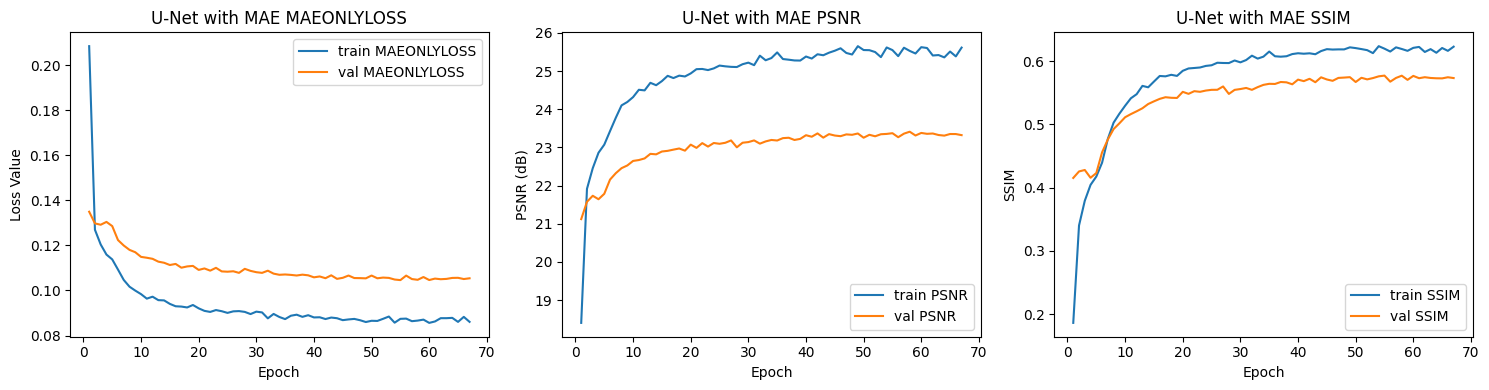

In [17]:
# --- 13.3 Plot Train vs Val

plot_three_metrics(history_mae, title_prefix = "U-Net with MAE")

In [18]:
# --- 13.4 Save U-Net with MAE

final_model_mae.save("model_mae.keras")

### MAE + perceptual alpha = 0.005

In [19]:
# --- 14.1 Compile U-Net with MAE + Perceptual (alpha=0.005)

final_model_a005.compile(
    optimizer = optimizer_a005,     # Mixed precision opt
    loss = sr_loss_block5,
    metrics = [
        perceptual_block5,
        pixel_loss,
        psnr_metric,
        ssim_metric
    ]
)

In [20]:
# --- 14.2 Train U-Net with MAE + Perceptual (alpha=0.005)

history_a005  = final_model_a005.fit(train_ds,
                                  validation_data = val_ds,
                                  epochs = EPOCHS,
                                  callbacks = callbacks_a005
)

Epoch 1/100


2025-08-16 12:55:24.670139: E external/local_xla/xla/service/slow_operation_alarm.cc:65] Trying algorithm eng0{} for conv (f16[32,64,64,256]{3,2,1,0}, u8[0]{0}) custom-call(f16[32,64,64,256]{3,2,1,0}, f16[256,3,3,256]{3,2,1,0}), window={size=3x3 pad=1_1x1_1}, dim_labels=b01f_o01i->b01f, custom_call_target="__cudnn$convBackwardInput", backend_config={"cudnn_conv_backend_config":{"activation_mode":"kNone","conv_result_scale":1,"leakyrelu_alpha":0,"side_input_scale":0},"force_earliest_schedule":false,"operation_queue_id":"0","wait_on_operation_queues":[]} is taking a while...
2025-08-16 12:55:31.887818: E external/local_xla/xla/service/slow_operation_alarm.cc:133] The operation took 8.217810383s
Trying algorithm eng0{} for conv (f16[32,64,64,256]{3,2,1,0}, u8[0]{0}) custom-call(f16[32,64,64,256]{3,2,1,0}, f16[256,3,3,256]{3,2,1,0}), window={size=3x3 pad=1_1x1_1}, dim_labels=b01f_o01i->b01f, custom_call_target="__cudnn$convBackwardInput", backend_config={"cudnn_conv_backend_config":{"activ

59/60 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - loss: 0.2727 - mean_absolute_error: 0.2674 - perceptual_block5: 1.0644 - psnr_metric: 16.5513 - ssim_metric: 0.1442

2025-08-16 12:58:07.579385: E external/local_xla/xla/service/slow_operation_alarm.cc:65] Trying algorithm eng0{} for conv (f16[20,128,128,128]{3,2,1,0}, u8[0]{0}) custom-call(f16[20,128,128,128]{3,2,1,0}, f16[128,3,3,128]{3,2,1,0}), window={size=3x3 pad=1_1x1_1}, dim_labels=b01f_o01i->b01f, custom_call_target="__cudnn$convBackwardInput", backend_config={"cudnn_conv_backend_config":{"activation_mode":"kNone","conv_result_scale":1,"leakyrelu_alpha":0,"side_input_scale":0},"force_earliest_schedule":false,"operation_queue_id":"0","wait_on_operation_queues":[]} is taking a while...
2025-08-16 12:58:12.232966: E external/local_xla/xla/service/slow_operation_alarm.cc:133] The operation took 5.653678783s
Trying algorithm eng0{} for conv (f16[20,128,128,128]{3,2,1,0}, u8[0]{0}) custom-call(f16[20,128,128,128]{3,2,1,0}, f16[128,3,3,128]{3,2,1,0}), window={size=3x3 pad=1_1x1_1}, dim_labels=b01f_o01i->b01f, custom_call_target="__cudnn$convBackwardInput", backend_config={"cudnn_conv_backend_config"

60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - loss: 0.2713 - mean_absolute_error: 0.2660 - perceptual_block5: 1.0627 - psnr_metric: 16.5953 - ssim_metric: 0.1455
Epoch 1: val_loss improved from inf to 0.14164, saving model to checkpoint_a005.keras
60/60 ━━━━━━━━━━━━━━━━━━━━ 319s 3s/step - loss: 0.2700 - mean_absolute_error: 0.2647 - perceptual_block5: 1.0611 - psnr_metric: 16.6379 - ssim_metric: 0.1468 - val_loss: 0.1416 - val_mean_absolute_error: 0.1360 - val_perceptual_block5: 1.1230 - val_psnr_metric: 20.9822 - val_ssim_metric: 0.4133 - learning_rate: 5.0000e-04
Epoch 2/100
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - loss: 0.1342 - mean_absolute_error: 0.1298 - perceptual_block5: 0.8868 - psnr_metric: 21.5589 - ssim_metric: 0.3430
Epoch 2: val_loss improved from 0.14164 to 0.13831, saving model to checkpoint_a005.keras
60/60 ━━━━━━━━━━━━━━━━━━━━ 91s 2s/step - loss: 0.1342 - mean_absolute_error: 0.1298 - perceptual_block5: 0.8865 - psnr_metric: 21.5629 - ssim_metric: 0.3432 - val_loss: 0.1383 

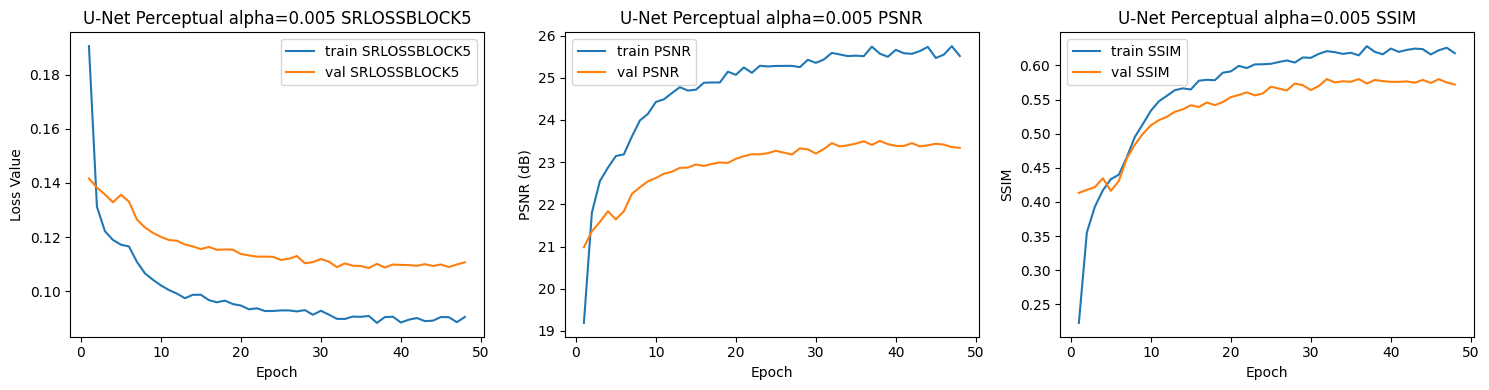

In [21]:
# --- 14.3 Plot Train vs Val

plot_three_metrics(history_a005, title_prefix = "U-Net Perceptual alpha=0.005")

In [22]:
# --- 14.4 Save U-Net with MAE + Perceptual (alpha=0.005)

final_model_a005.save("model_a005.keras")

### MAE + perceptual alpha = 0.02

In [23]:
# --- 15.1 Compile U-Net with MAE + Perceptual (alpha=0.02)

final_model_a02.compile(
    optimizer = optimizer_a02,         # Mixed precision opt
    loss = sr_loss_block5_alpha,
    metrics = [
        perceptual_block5,
        pixel_loss,
        psnr_metric,
        ssim_metric
    ]
)

In [24]:
# --- 15.2 Train U-Net with MAE + Perceptual (alpha=0.02)

history_a02  = final_model_a02.fit(train_ds,
                                    validation_data = val_ds,
                                    epochs = EPOCHS,
                                    callbacks = callbacks_a02
)

Epoch 1/100
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - loss: 0.2757 - mean_absolute_error: 0.2555 - perceptual_block5: 1.0082 - psnr_metric: 16.8242 - ssim_metric: 0.1406
Epoch 1: val_loss improved from inf to 0.15279, saving model to checkpoint_a02.keras
60/60 ━━━━━━━━━━━━━━━━━━━━ 181s 2s/step - loss: 0.2745 - mean_absolute_error: 0.2544 - perceptual_block5: 1.0068 - psnr_metric: 16.8644 - ssim_metric: 0.1418 - val_loss: 0.1528 - val_mean_absolute_error: 0.1313 - val_perceptual_block5: 1.0712 - val_psnr_metric: 21.4296 - val_ssim_metric: 0.4277 - learning_rate: 5.0000e-04
Epoch 2/100
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - loss: 0.1457 - mean_absolute_error: 0.1292 - perceptual_block5: 0.8285 - psnr_metric: 21.8166 - ssim_metric: 0.3300
Epoch 2: val_loss improved from 0.15279 to 0.14984, saving model to checkpoint_a02.keras
60/60 ━━━━━━━━━━━━━━━━━━━━ 92s 2s/step - loss: 0.1457 - mean_absolute_error: 0.1291 - perceptual_block5: 0.8287 - psnr_metric: 21.8207 - ssim_metric: 0.3303 - val_los

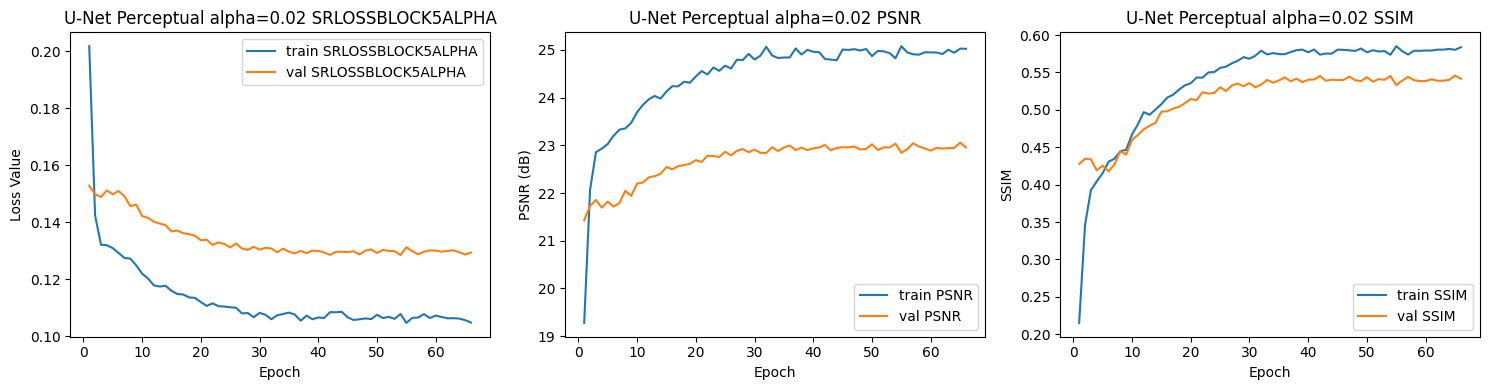

In [25]:
# --- 15.3 Plot Train vs Val

plot_three_metrics(history_a02, title_prefix = "U-Net Perceptual alpha=0.02")

In [26]:
# --- 15.4 Save U-Net with MAE + Perceptual (alpha=0.02)

final_model_a02.save("model_a02.keras")

# Evaluation & Visualization

In [27]:
# --- 16 Load models + Evaluation

custom_objects = {
    "mae_only_loss": mae_only_loss,
    "sr_loss_block5": sr_loss_block5,
    "sr_loss_block5_alpha": sr_loss_block5_alpha,
    "perceptual_block5": perceptual_block5,
    "pixel_loss": pixel_loss,
    "psnr_metric": psnr_metric,
    "ssim_metric": ssim_metric,
    "PixelShuffle": PixelShuffle 
}

# 16.1 load models
model_mae  = load_model("model_mae.keras",   custom_objects=custom_objects,   safe_mode=False)
model_a005 = load_model("model_a005.keras",  custom_objects=custom_objects,   safe_mode=False)
model_a02  = load_model("model_a02.keras",   custom_objects=custom_objects,   safe_mode=False)
print("Models loaded successfully.")

# 16.2 Evaluation of each model on the test data
res_mae = model_mae.evaluate(test_ds, return_dict=True)
res_a005 = model_a005.evaluate(test_ds, return_dict=True)
res_a02 = model_a02.evaluate(test_ds, return_dict=True)
print("\nModel evaluated.")

Models loaded successfully.
9/9 ━━━━━━━━━━━━━━━━━━━━ 20s 1s/step - loss: 0.1018 - mae_only_loss: 0.1016 - psnr_metric: 23.7478 - ssim_metric: 0.5967
9/9 ━━━━━━━━━━━━━━━━━━━━ 25s 2s/step - loss: 0.1036 - mean_absolute_error: 0.0985 - perceptual_block5: 0.9682 - psnr_metric: 24.0343 - ssim_metric: 0.6093
9/9 ━━━━━━━━━━━━━━━━━━━━ 19s 974ms/step - loss: 0.1222 - mean_absolute_error: 0.1030 - perceptual_block5: 0.9578 - psnr_metric: 23.5740 - ssim_metric: 0.5769

Model evaluated.


## Evaluation

In [28]:
#--- 17 Evaluation

print("\n--- FINAL EVALUATION RESULTS ---\n")
print("Evaluation U-Net + MAE")
print(f"Test Loss (MAE): {res_mae['loss']:.4f}")
print(f"Test PSNR: {res_mae['psnr_metric']:.4f}")
print(f"Test SSIM: {res_mae['ssim_metric']:.4f}")
print("-" * 30)

print("Evaluation U-Net + Perceptual Loss (alpha=0.005)")
print(f"Test Combined Loss: {res_a005['loss']:.4f}")
print(f"Test Perceptual Loss: {res_a005['perceptual_block5']:.4f}")
print(f"Test MAE: {res_a005['mean_absolute_error']:.4f}")
print(f"Test PSNR: {res_a005['psnr_metric']:.4f}")
print(f"Test SSIM: {res_a005['ssim_metric']:.4f}")
print("-" * 30)

print("Evaluation U-Net + Perceptual Loss (alpha=0.02)")
print(f"Test Combined Loss: {res_a02['loss']:.4f}")
print(f"Test Perceptual Loss: {res_a02['perceptual_block5']:.4f}")
print(f"Test MAE: {res_a02['mean_absolute_error']:.4f}")
print(f"Test PSNR: {res_a02['psnr_metric']:.4f}")
print(f"Test SSIM: {res_a02['ssim_metric']:.4f}")


--- FINAL EVALUATION RESULTS ---

Evaluation U-Net + MAE
Test Loss (MAE): 0.0969
Test PSNR: 24.1408
Test SSIM: 0.6075
------------------------------
Evaluation U-Net + Perceptual Loss (alpha=0.005)
Test Combined Loss: 0.0995
Test Perceptual Loss: 0.9851
Test MAE: 0.0936
Test PSNR: 24.3777
Test SSIM: 0.6178
------------------------------
Evaluation U-Net + Perceptual Loss (alpha=0.02)
Test Combined Loss: 0.1195
Test Perceptual Loss: 0.9856
Test MAE: 0.0993
Test PSNR: 23.8435
Test SSIM: 0.5799


In [29]:
# --- 18 Preparation for the Patch Visualization

# 18.1 Select a random image from test data
sample_path_hr = random.choice(test_paths)
hr_full_image = tf.image.convert_image_dtype(
    tf.io.decode_png(tf.io.read_file(sample_path_hr), channels=CH),
    tf.float32
)

# 18.2 Extract HR patch [0, 1] for ground truth visualization
hr_patch_gt = tf.image.resize_with_crop_or_pad(hr_full_image, PATCH_H, PATCH_W)

# 18.3 Degrade HR Patch using the pipeline to get LR patch [0, 1]
lr_patch_degraded_0_1 = degradation_pipeline_np(hr_patch_gt.numpy())

# 18.4 Normalize the degraded LR patch to [-1, 1] for model input
lr_patch_input = (lr_patch_degraded_0_1 * 2.0) - 1.0

# 18.5 HR ground truth for the model is also [-1, 1]
hr_patch_for_model = (hr_patch_gt.numpy() * 2.0) - 1.0

# 18.6 Model prediction (input is [-1, 1], output is [-1, 1])
sr_patch_predicted_mae  = model_mae.predict(lr_patch_input[None, ...])[0]
sr_patch_predicted_a005 = model_a005.predict(lr_patch_input[None, ...])[0]
sr_patch_predicted_a02  = model_a02.predict(lr_patch_input[None, ...])[0]

1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


## Patch Visualization

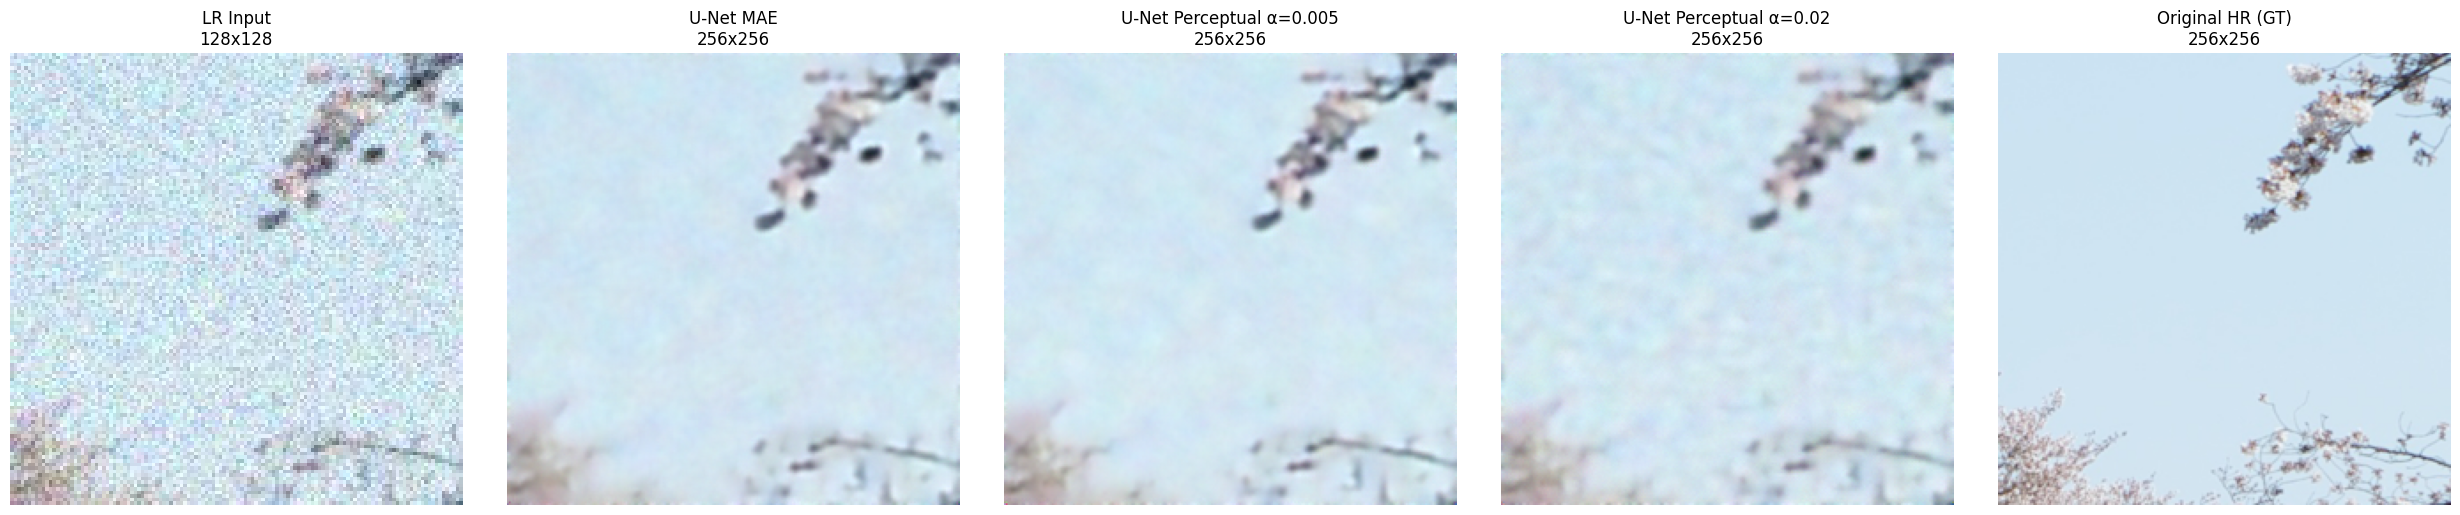

In [30]:
# --- 19 Visualization of the Model Predicion

def denorm(img):
    img_f32 = tf.cast(img, tf.float32)
    return tf.clip_by_value((img_f32 + 1.0) / 2.0, 0, 1)

plt.figure(figsize=(25, 5))

# 1. LR Input (denormalized from [-1, 1] for viewing)
plt.subplot(1, 5, 1)
plt.title(f"LR Input\n{PATCH_LR_H}x{PATCH_LR_W}")
plt.imshow(denorm(lr_patch_input))
plt.axis("off")

# 2. U-Net with MAE
plt.subplot(1, 5, 2)
plt.title(f"U-Net MAE\n{PATCH_H}x{PATCH_W}")
plt.imshow(denorm(sr_patch_predicted_mae))
plt.axis("off")

# 3. U-Net with MAE + Perceptual (alpha=0.005)
plt.subplot(1, 5, 3)
plt.title(f"U-Net Perceptual α=0.005\n{PATCH_H}x{PATCH_W}")
plt.imshow(denorm(sr_patch_predicted_a005))
plt.axis("off")

# 4. U-Net with MAE + Perceptual (alpha=0.02)
plt.subplot(1, 5, 4)
plt.title(f"U-Net Perceptual α=0.02\n{PATCH_H}x{PATCH_W}")
plt.imshow(denorm(sr_patch_predicted_a02))
plt.axis("off")

# 5. Original HR Patch (Ground Truth)
plt.subplot(1, 5, 5)
plt.title(f"Original HR (GT)\n{PATCH_H}x{PATCH_W}")
plt.imshow(hr_patch_gt) # Already in [0, 1] range
plt.axis("off")

plt.tight_layout()
plt.show()

The following function handles inference on full-sized images, which can be tricky. Here is the general "plot":
* Padding **(20.1-20.3)**: An image's dimensions might not be perfectly divisible by the patch stride... This would cause issues when covering the entire image. To solve this, the addition of padding ensure the dimensions are a perfect multiple of the stride.  This is done thanks to "mode="reflect"" -> reflects the pixels from the edge.
* Extract patches **(20.4)**: "tf.image.extract_patches" performs the sliding window operation returning a single batch of all the 128x128 LR patches.
* Predict **(20.5)**: "predict()" predict on the entire batch of patches.
* Reconstruction & Blending **(20.6-20.10)**: placing a predicted HR patch side-by-side to another might not perfectcly match the edge. The solution is to **blend** the patches in the overlapping areas.
    * "Hann Window" **(20.7)** is used for this. It has a value of 1.0 in the center and smootly fades to 0.0 at the edges.
    * Each predicted HR patch is multiply by the Hann Window **(20.8)** before adding it to the "big" final image (final_hr). In this way the center of each patch contributes fully, while the edges contributes less.
    * In the overlapping ares, a pixel gets contributions from multiple patches. The "weight_map" **(20.9)** keeps track of the sum of these Hann Window at every pixel. Thanks to this, it perfoms a weighted average of the predictions in the overlapping ares. This creates better result.
    * Finally, the initial padding are crop off **(20.10)**

In [31]:
# --- 20 Full Image Inference Functions

def predict_full_image_tiled(model, lr_image_norm, patch_size=128, overlap=32, batch_size=8):
# model: the trained super-resolution model.
# lr_image_norm: the low-resolution input image normalized to [-1, 1].
# patch_size: the size of LR patches to predict on.
# overlap: the overlap between patches.
# batch_size: batch size for model prediction.
    
    # 20.1 Get image dimensions and calculate stride
    lr_h, lr_w, C = lr_image_norm.shape
    stride = patch_size - overlap

    # 20.2 Calc padding needed for the image to be divisible by the stride
    # This ensures that the entire image is covered by patches.
    n_patches_h = math.ceil(max(0, lr_h - patch_size) / stride) + 1
    n_patches_w = math.ceil(max(0, lr_w - patch_size) / stride) + 1
    pad_h = (n_patches_h - 1) * stride + patch_size - lr_h
    pad_w = (n_patches_w - 1) * stride + patch_size - lr_w
    
    # 20.3 Apply reflection padding to minimize edge artifacts
    lr_padded = np.pad(lr_image_norm, ((0, pad_h), (0, pad_w), (0, 0)), mode='reflect')

    # 20.4 Extract patches
    # The input image is expanded to a 4D tensor (batch, height, width, channels)
    patches = tf.image.extract_patches(
        images=lr_padded[None, ...],
        sizes=[1, patch_size, patch_size, 1],
        strides=[1, stride, stride, 1],
        rates=[1, 1, 1, 1],
        padding='VALID'
    )
    # Reshape the extracted patches into a batch that the model can process
    patches = tf.reshape(patches, [-1, patch_size, patch_size, C])

    # 20.5 Run model prediction on the batch of patches (already in  [-1, 1] range)
    preds_norm = model.predict(patches, batch_size=batch_size, verbose=0)   # Output is [-1, 1]

    # 20.6 Reconstruct the full HR image from the predicted HR patches
    patch_hr_size = patch_size * UPSCALE_FACTOR
    stride_hr = stride * UPSCALE_FACTOR
    hr_h, hr_w = lr_padded.shape[0] * UPSCALE_FACTOR, lr_padded.shape[1] * UPSCALE_FACTOR
    
    # Create an empty canvas for the final image and a weight map for blending
    final_hr = np.zeros((hr_h, hr_w, C), dtype=np.float32)
    weight_map = np.zeros_like(final_hr)

    # 20.7 Create a 2D Hann window for smooth blending
    # The window gives more weight to the pixels in the center of a patch and less to the edges.
    hann_1d = np.hanning(patch_hr_size)
    window_2d = np.outer(hann_1d, hann_1d)[..., None]

    # 20.8 Loop through patches, apply the window, and add them to the canvas
    idx = 0
    for iy in range(n_patches_h):
        for ix in range(n_patches_w):
            y, x = iy * stride_hr, ix * stride_hr
            # Add the predicted patch, weighted by the Hann window
            final_hr[y:y+patch_hr_size, x:x+patch_hr_size, :] += preds_norm[idx] * window_2d
            # Add the window itself to the weight map
            weight_map[y:y+patch_hr_size, x:x+patch_hr_size, :] += window_2d
            idx += 1

    # 20.9 Normalize the reconstructed image by the weight map
    # This averages the overlapping regions weighted by the Hann window.
    final_hr = final_hr / (weight_map + 1e-8)
    
    # 20.10 Crop the image back to its original size, removing the padding
    orig_hr_h, orig_hr_w = lr_h * UPSCALE_FACTOR, lr_w * UPSCALE_FACTOR
    final_hr_cropped = final_hr[:orig_hr_h, :orig_hr_w, :]

    return final_hr_cropped # The output is still in [-1, 1] range

## Full Image Visualization


--- Generating SR image for model: U-Net MAE ---

--- Generating SR image for model: U-Net Perceptual α=0.005 ---

--- Generating SR image for model: U-Net Perceptual α=0.02 ---


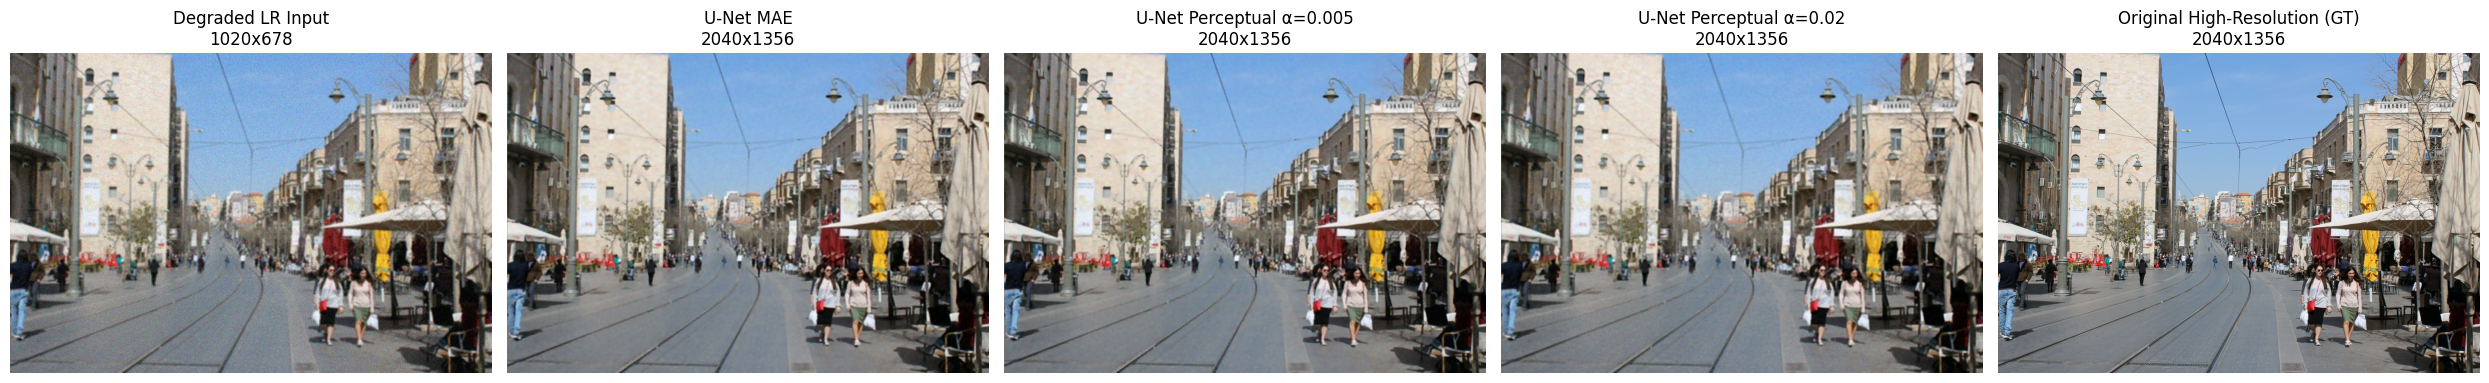

In [32]:
# --- 21 Final Full Image Visualization 

# 21.1 Group the loaded models for easy iteration
models_to_evaluate = {
    "U-Net MAE": model_mae,
    "U-Net Perceptual α=0.005": model_a005,
    "U-Net Perceptual α=0.02": model_a02
}
sr_images = {}

# 21.2 Select a random full-size image from the test set
sample_path_full = random.choice(test_paths)
hr_full_original = tf.image.convert_image_dtype(tf.io.decode_png(
    tf.io.read_file(sample_path_full), channels=CH),tf.float32).numpy()     # HR image in [0, 1]

# 21.3 Create the Low-Resolution input using the degradation pipeline
lr_full_input_degraded = degradation_pipeline_np(hr_full_original)          # Result is [0, 1]

# 21.4 Normalize the LR input to [-1, 1] for the models
lr_model_input = (lr_full_input_degraded * 2.0) - 1.0

# 21.5 Generate a super-resolved & restored image for each model
for name, model in models_to_evaluate.items():
    print(f"\n--- Generating SR image for model: {name} ---")
    # The new function expects [-1, 1] and returns [-1, 1]
    sr_image_norm = predict_full_image_tiled(
        model,
        lr_model_input,
        patch_size=PATCH_LR_W,
        overlap=32,
        batch_size=BATCH_SIZE
    )
    # Denormalize the final result to [0, 1] for plotting
    sr_images[name] = np.clip((sr_image_norm + 1.0) / 2.0, 0.0, 1.0)

# 21.6 Visualize the results for all models
plt.figure(figsize=(25, 10))

# 1. Degraded Low-Res Input
plt.subplot(1, 5, 1)
plt.title(f"Degraded LR Input\n{lr_full_input_degraded.shape[1]}x{lr_full_input_degraded.shape[0]}", fontsize=12)
plt.imshow(lr_full_input_degraded)
plt.axis("off")

# 2-4. Super-Resolved Outputs from each model
for i, (name, sr_img) in enumerate(sr_images.items()):
    plt.subplot(1, 5, i + 2)
    plt.title(f"{name}\n{sr_img.shape[1]}x{sr_img.shape[0]}", fontsize=12)
    plt.imshow(sr_img)
    plt.axis("off")

# 5. Original High-Res (Ground Truth)
plt.subplot(1, 5, 5)
plt.title(f"Original High-Resolution (GT)\n{hr_full_original.shape[1]}x{hr_full_original.shape[0]}", fontsize=12)
plt.imshow(hr_full_original)
plt.axis("off")

plt.tight_layout()
plt.show()